<a href="https://colab.research.google.com/github/Joseikwang/Time-Series/blob/main/ANOMALY_DETECTION_USING_AUTOENCODERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection with Auto-Encoders**

# **Loading Libraries**

In [ ]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1)
tf.random.set_seed(1)
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.18.0


**This excercise covers:**

Anomaly Detection

LSTM Autoencoders

S&P 500 Index Data

LSTM Autoencoder in Tensorflow

Finding Anomalies

**What is Anomaly detection?**

Anomaly detection is the process of identifying uncommon events or data points.

It has a variety of applications, such as detecting fraudulent activity in banking, detecting tumors in medical imaging, and identifying errors in written text

**Methods:**

A lot of supervised and unsupervised approaches. Some of the approaches include:
One-class SVMs, Bayesian Networks, Cluster analysis, and (of course) Neural Networks.

**Autoencoders**

It is an unsupervised learning technique, trained using supervised learning methods. During training, the autoencoder adjusts its weights and biases to minimize the reconstruction error by using techniques such as backpropagation and gradient descent. By minimizing the reconstruction error, the autoencoder learns to encode and decode the input data effectively:

Creates a compressed representation of the input data
This encoding captures the most important features of the data and enable the model to generate an output that is similar to the original input.
In other words, the autoencoder is trained to reconstruct the input data from a compressed representation of it.
The applications are image compression, anomaly detection, and feature learning.

# **Importing Data**

In [ ]:
df = pd.read_csv('/content/spx.csv', parse_dates=['date'], index_col='date')

df.head()

<ipython-input-36-868230d68324>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/spx.csv', parse_dates=['date'], index_col='date')


,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


# **Visualize the Time series**

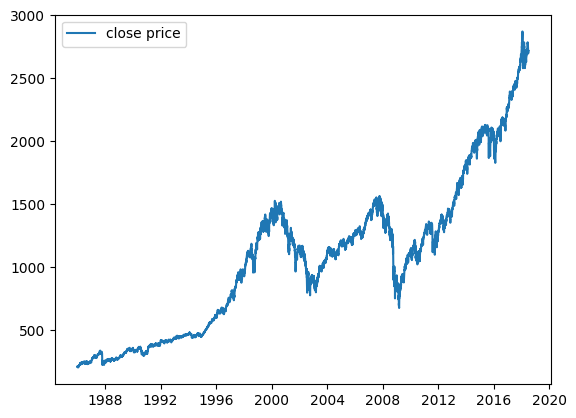

In [ ]:
plt.plot(df, label='close price')
plt.legend()

Over the past years, there has been a promising trend that may present a good investment opportunity. It might be worth considering investing in this trend. However, it's important to determine the best time to buy or sell. Additionally, it's valuable to identify anomalies or sudden changes as early as possible.

# **Data Preprocessing**

Steps:

use 95% of data to train the model

Rescale the data using the train data and test data

split the data into subsequences ( sequences with 30 days worth of historical data:

In [ ]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

(7782, 1) (410, 1)


<ipython-input-38-2782f44b0353>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-38-2782f44b0353>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [ ]:
def create_seq(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_seq(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_seq(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)
print(X_test.shape)

(7752, 30, 1)
(380, 30, 1)


# **Modeling**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed( keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

The RepeatVector layer duplicates the input n times,
Setting return_sequences=True in the LSTM layer makes it return a sequence.

The TimeDistributed layer creates a - vector with a length equal to the number of outputs from the preceding layer.

By combining these layers, we can create an LSTM Autoencoder that is ready for training.

The training process is similar to that of a regular LSTM model. Finally, we added a TimeDistributed(Dense(X_train.shape[2])) layer at the end of the network to obtain the output, where X_train.shape[2] represents the number of features in the input data

**Model Trainig**

In [ ]:
history = model.fit( X_train, y_train, epochs=10, batch_size=32,
                    validation_split=0.1, shuffle=False)

Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.3011 - val_loss: 0.2345
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.1141 - val_loss: 0.2781
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.1815 - val_loss: 0.3154
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.2541 - val_loss: 0.3201
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.2664 - val_loss: 0.2782
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.2226 - val_loss: 0.2478
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.2380 - val_loss: 0.2240
Epoch 8/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.2441 - val_loss: 0.2001
Epoch 9/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.2625 - val_loss: 0.1955
Epoch 10/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.2651 - val_loss: 0.1815


# **Evaluation**

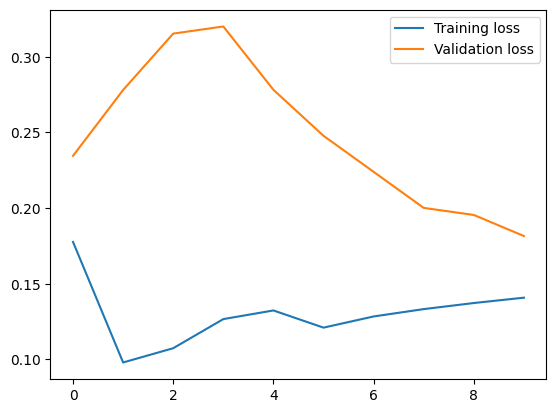

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Validation loss has increased in the end of model training. Callbacks such as Early stopping could be used to avoid this.

In [ ]:
model.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5100


0.6245485544204712

The output indicates that the evaluation process was carried out on 12 batches, and the average loss on the test set was 0.7052039504051208

The value 0.7052039504051208 printed after the batch-level output is the final loss value returned by the evaluate function. It implies that the model is performing well in terms of detecting anomalies in the test data. A lower loss value indicates better performance.

# **Detecting Anomalies**

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


<ipython-input-47-0625a7148ea6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True)


<Axes: ylabel='Density'>

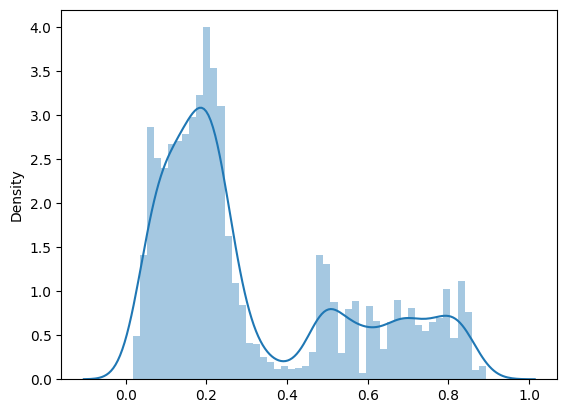

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

Pick a threshold of 0.8, as not much of the loss is larger than that. When the error is larger than that, we’ll declare that example an anomaly

In [ ]:
THRESHOLD = 0.8
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

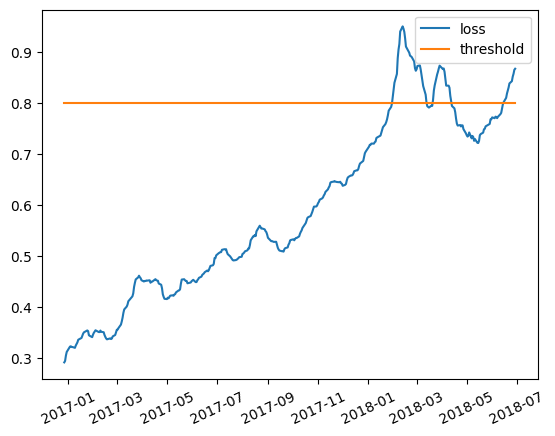

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()

It seems that we are effectively applying a threshold to filter out extreme values.

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-01-31,0.813036,0.8,True,3.435135
2018-02-01,0.827790,0.8,True,3.431698
2018-02-02,0.839460,0.8,True,3.319282
2018-02-05,0.856790,0.8,True,3.106679
2018-02-06,0.887822,0.8,True,3.193456


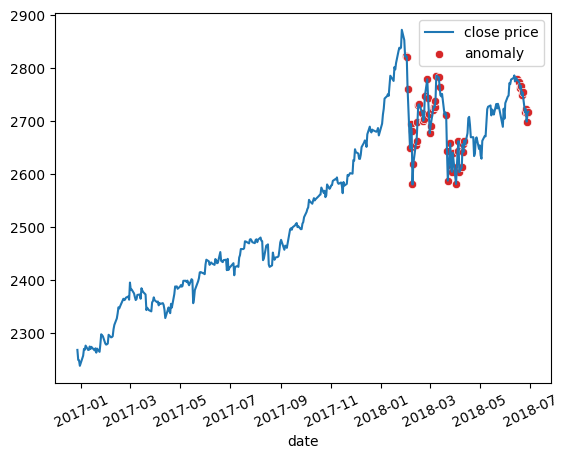

In [ ]:
anomalies_close = anomalies[["close"]].values.flatten()
anomalies_close = anomalies_close.reshape(-1, 1) # Reshape to a 2D array
anomalies_close = scaler.inverse_transform(anomalies_close)

plt.plot(test[TIME_STEPS:].index,
         scaler.inverse_transform(test[TIME_STEPS:][["close"]]),
         label='close price')

# convert it to a 1D array for the plot
anomalies_close = anomalies_close.flatten()
sns.scatterplot(x=anomalies.index,
                y=anomalies_close,
                color=sns.color_palette()[3],
                label='anomaly'
               )

plt.xticks(rotation=25)
plt.legend()

On a close inspection, we can see that the anomalies, represented by the red dots, seem to be present mainly in areas where there are sudden changes in the closing price.